In [239]:
import spacy

nlp = spacy.load("fr_core_news_lg")

In [ ]:
from pathlib import Path

import pandas as pd

DATA_FOLDER = Path(".") / "data"
PARTIES = list(DATA_FOLDER.glob("*.csv"))

dataset = pd.concat([pd.read_csv(party) for party in PARTIES]).reset_index(drop=True)

# The decision was made to aggregate all tweets of users to obtain a large corpus
# per user instead of invidivual tweets, which don't embed much political signal.
dataset = dataset.groupby(["user_id", "account"]).agg({'tweet': ' '.join}).rename(columns={"tweet": "tweets"}).reset_index()
dataset

In [241]:
import re
import numpy as np

def tokenize(tweet):
    """
    Tokenize tweets in a (very) naive way. Only remove hashtags, mentions and links.
    It should not be done for a robust embedding system, as they carry signal.
    However, spacy default embeddings returns 0 for such tokens, but are not ignored for document vector.
    The regex comes from 'https://stackoverflow.com/a/8377440'
    """
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

embeddings = np.array([t.vector for t in nlp.pipe(dataset["tweets"].apply(tokenize))])
embeddings

array([[-0.38675204,  1.3124926 , -0.5415515 , ...,  0.8386813 ,
         0.2970662 , -0.07293238],
       [-0.00392179,  1.5777224 , -0.37912554, ...,  0.35595903,
         1.1802586 , -0.82830554],
       [ 0.47550994, -0.29082027, -1.5245868 , ...,  0.1115342 ,
        -0.2514086 , -0.6333132 ],
       ...,
       [ 0.511381  , -0.84190017, -1.4074489 , ..., -0.2996716 ,
        -0.01470037, -0.45555565],
       [ 0.17149371, -0.15676898, -1.6453233 , ...,  0.4543721 ,
         0.24613631,  0.02205929],
       [ 0.6812797 , -0.7438901 , -2.1405072 , ..., -0.03313997,
        -0.04514764, -0.82873935]], dtype=float32)

In [242]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2, init='random').fit_transform(embeddings)

docs_2d = pd.DataFrame(t_sne, columns=["x", "y"])
docs_2d["category"] = dataset["account"].astype("category")
docs_2d

,x,y,category
0,-25.955338,-21.635967,EELV
1,-33.781380,-23.053221,lesRepublicains
2,-1.490272,3.580803,FranceInsoumise
3,-33.995777,-22.054688,FranceInsoumise
4,29.112741,-3.041198,FranceInsoumise
...,...,...,...
1318,33.495647,7.411030,EELV
1319,33.495823,7.411128,FranceInsoumise
1320,33.495472,7.411077,lesRepublicains
1321,8.191226,5.183954,lesRepublicains


<AxesSubplot: xlabel='x', ylabel='y'>

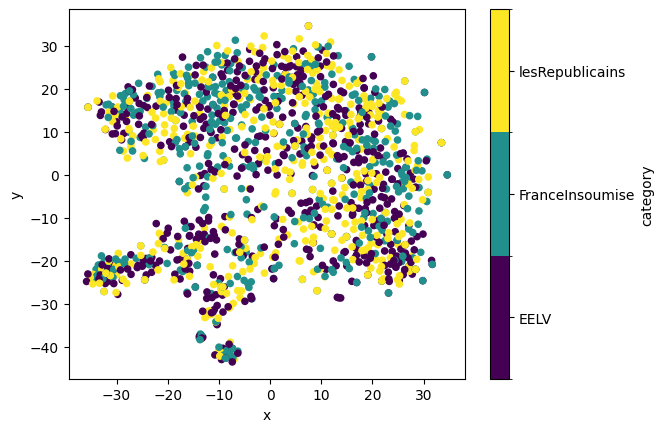

In [243]:
docs_2d.plot.scatter(x="x", y="y", c="category", colormap="viridis")

<AxesSubplot: xlabel='x', ylabel='y'>

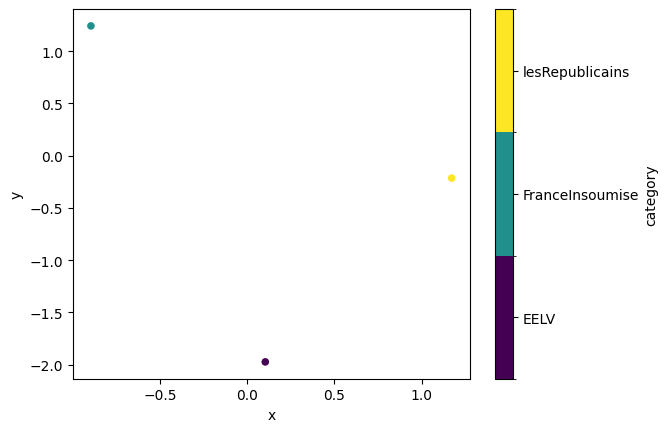

In [244]:
centroids = docs_2d.groupby('category').mean()
centroids["category"] = centroids.index
centroids.plot.scatter(x="x", y="y", c="category", colormap="viridis")

In [ ]:
train_set = dataset.sample(frac=.8)
test_set = dataset.drop(train_set.index)

train_X, test_X = embeddings[train_set.index], embeddings[test_set.index]
train_y, test_y = train_set["account"], test_set["account"]

In [252]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(train_X, train_y)

In [ ]:
def exp_predict(index_to_predict):
    row = dataset.iloc[index_to_predict]
    print(f"Predicting user, expected account: {row['account']}")

    to_predict = test_X[index_to_predict].reshape(1, -1)
    predicted = knn.predict(to_predict)
    print(f"Predicted {predicted[0]}")

    nearest_neighbors = knn.kneighbors(to_predict)
    for distance, ind in zip(nearest_neighbors[0][0], nearest_neighbors[1][0]):
        nearest = dataset.iloc[ind]
        print(f"nearest includes: '{nearest['user_id']}' with a distance of {distance}, whose account was: '{nearest['account']}'\n")


exp_predict(test_y.index[0])

In [255]:
from sklearn.metrics import accuracy_score

pred_y = knn.predict(test_X)

accuracy_score(test_y, pred_y)

0.32452830188679244